Dataset generator Notebook to create training/validation/test datasets from the raw database.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import operator
import os
from os.path import basename
from pathlib import Path
from shutil import copyfile

In [2]:
"""
Visualize the image distribution in the classes
input
    classes: Dictionary with name/image number pairs
"""
def visualizeImageDistribution(classes):

    f, ax = plt.subplots(1)

    totalClasses = (len(classes))
    # Compute the x and y coordinates
    x = np.arange(0, totalClasses, 1)
    y = ([])

    for key, value in classes.items():
        y = np.append(y, value)

    # Plot the points using matplotlib
    ax.plot(x, y)
    ax.set_ylim(ymin=0)
    plt.title('Distribution of images')
    plt.xlabel('Class index')
    plt.ylabel('#images in class')
    plt.show(f)  # call plt.show() to make graphics appear
    print('---')

In [3]:
"""
Show statistics of the classes
input
    classes: Dictionary with name/image number pairs
"""
def showStats(classes):
    
    totalClasses = (len(classes))
    totalImages = 0
    
    for images in classes.values(): 
        totalImages += images
    
    values = ([])
    for key, value in classes.items():
        values = np.append(values, value)
    
    print('# images: %d' % totalImages)
    print('# classes: %d' % totalClasses)
    print('')
    print('Class with most images: %s' % str( max(classes.items(), key=operator.itemgetter(1))[0:2] ) )
    print('Class with least images: %s' % str( min(classes.items(), key=operator.itemgetter(1))[0:2] ) )
    print('')
    print('Avg. per class: %d' % np.average(values))
    print('Mean: %d' % np.mean(values))
    print('---')

In [4]:
"""
Raw data analyse
input
    path: Path to the raw dataset
"""
def evaluateRawDataset(path):

    classes = {}

    for filename in Path(path).glob("*/"):

        classImgCounter = 0

        for file in (Path(path) / basename(filename)).glob("**/*.jpg"):
            classImgCounter += 1

        classes[filename.name] = classImgCounter
    
    print('RAW DATA OVERVIEW')
    visualizeImageDistribution(classes)
    showStats(classes)

    #for name, number in classes.items():
        #print('%s: %d' % (name, number))

In [5]:
def subDatasetVisitor(sourcePath, labelsFile, currentClassIndexBase,
                      trainingPath, validationPath, testPath, 
                      trainingClasses, validationClasses, testClasses, 
                      trainingImagesCreated, validationImagesCreated, testImagesCreated,
                      trainingRatio, validationRation, testRatio):
    
    #visit every class directory from the raw dataset
    for filename in Path(sourcePath).glob("*/"):
        
        currentClassIndexBase += 1
        currentClassNameWithKey = 'n' + str(currentClassIndexBase).zfill(8) + '-' + basename(filename)
        
        #add current class name to labels
        labelsFile.write(currentClassNameWithKey + '\n')

        #define current training/validation/test subdirs
        currentTraining = Path(trainingPath) / currentClassNameWithKey
        currentValication = Path(validationPath) / currentClassNameWithKey
        currentTest = Path(testPath) / currentClassNameWithKey
        
        #create current training/validation/test subdirs
        os.makedirs(currentTraining, exist_ok=True)
        os.makedirs(currentValication, exist_ok=True)
        os.makedirs(currentTest, exist_ok=True)
        
        classImages = ([])
        classImageCounter = 0

        #visit every file in a class
        for file in (Path(sourcePath) / basename(filename)).glob("**/*.jpg"):
            classImages = np.append(classImages, file)
            classImageCounter += 1

        #distribute images randomly between training/validation/test sets
        randomPermutation = np.random.permutation(classImageCounter)

        #calculate image numbers to training/validation/test sets
        numCurrentTestImages = math.ceil(classImageCounter*testRatio)
        numCurrentValidationImages = math.ceil(classImageCounter*validationRatio)
        numCurrentTrainingImages = classImageCounter - (numCurrentTestImages + numCurrentValidationImages)

        classTrainingImages = 0
        classValidationImages = 0
        classTestImages = 0

        #iterate through the class images in our generated random order
        for randomIndex in np.nditer(randomPermutation):

            #first, copy selected class images to the test subdir of the corresponding class
            if(numCurrentTestImages > 0):
                fileToCopy = classImages.item(randomIndex)
                copyfile(fileToCopy, Path(currentTest) / basename(fileToCopy))
                numCurrentTestImages -= 1
                classTestImages += 1

            #copy selected class images to the validation subdir of the corresponding class
            elif(numCurrentValidationImages > 0):
                fileToCopy = classImages.item(randomIndex)
                copyfile(fileToCopy, Path(currentValication) / basename(fileToCopy))
                numCurrentValidationImages -= 1
                classValidationImages += 1

            #copy selected class images to the training subdir of the corresponding class
            else:
                fileToCopy = classImages.item(randomIndex)
                copyfile(fileToCopy, Path(currentTraining) / basename(fileToCopy))
                numCurrentTrainingImages -= 1
                classTrainingImages += 1

        #after generating the training/validation/test sets of the current class, notify user
        print('Class %s (generated name: %s) - training: %d, validation: %d, test: %d image(s)' 
              % ( basename(filename), currentClassNameWithKey, classTrainingImages, classValidationImages, classTestImages) )
    
        #save class stats
        trainingClasses[filename.name] = classTrainingImages
        validationClasses[filename.name] = classValidationImages
        testClasses[filename.name] = classTestImages
    
        #save global stats
        trainingImagesCreated += classTrainingImages
        validationImagesCreated += classValidationImages
        testImagesCreated += classTestImages

In [6]:
"""
Builds up the training/validation/test datasets
input
    baseDataPath: Path to the base (raw) database
    trainingRatio: Ratio of the training images from the whole image set
    validationRatio: Ratio of the validation images from the whole image set
    testRatio: Ratio of the test images from the whole image set
"""
def buildDataset(baseDataPath, trainingRatio=0.7, validationRatio=0.2, testRatio=0.1):
    
    sourcePath = baseDataPath + 'raw data\\'
    generatePath = baseDataPath + 'dataset\\'

    #define the generated subdirectories
    trainingPath = generatePath + 'training\\'
    validationPath = generatePath + 'validation\\'
    testPath = generatePath + 'test\\'
    
    #define labels file name
    labelsFileName = 'labels.txt'

    allTrainingImages = 0
    allValidationImages = 0
    allTestImages = 0

    #create dataset root directory and training/validation/test subdirectories
    os.makedirs(Path(generatePath), exist_ok=True)
    os.makedirs(Path(trainingPath), exist_ok=True)
    os.makedirs(Path(validationPath), exist_ok=True)
    os.makedirs(Path(testPath), exist_ok=True)
    
    trainingImagesCreated = 0
    validationImagesCreated = 0
    testImagesCreated = 0
    
    trainingClasses = {}
    validationClasses = {}
    testClasses = {}
    
    print('*Start building dataset*')
    print('')
    
    #create labels file
    labelsFile = open(generatePath + labelsFileName, 'w')
    
    humansBaseId = int('01000000')
    catsBaseId = int('02000000')
    dogsBaseId = int('03000000')
    
    #visit every sub dataset from the raw dataset
    
    subDatasetVisitor(sourcePath + 'humans\\', labelsFile, humansBaseId,
                      trainingPath, validationPath, testPath, 
                      trainingClasses, validationClasses, testClasses, 
                      trainingImagesCreated, validationImagesCreated, testImagesCreated,
                      trainingRatio, validationRatio, testRatio)
    
    subDatasetVisitor(sourcePath + 'cats\\', labelsFile, catsBaseId,
                      trainingPath, validationPath, testPath, 
                      trainingClasses, validationClasses, testClasses, 
                      trainingImagesCreated, validationImagesCreated, testImagesCreated,
                      trainingRatio, validationRatio, testRatio)
    
    subDatasetVisitor(sourcePath + 'dogs\\', labelsFile, dogsBaseId,
                      trainingPath, validationPath, testPath, 
                      trainingClasses, validationClasses, testClasses, 
                      trainingImagesCreated, validationImagesCreated, testImagesCreated,
                      trainingRatio, validationRatio, testRatio)
    
    print('')
    print('Training set: %d image(s)' % trainingImagesCreated)
    print('Validation set: %d image(s)' % validationImagesCreated)
    print('Test set: %d image(s)' % testImagesCreated)
    print('')
    print('*Completed*')
    print('---')
    
    #visualize training/validation/test sets and stats
    print('TRAINING DATASET')
    visualizeImageDistribution(trainingClasses)
    showStats(trainingClasses)
    print('VALIDATION DATASET')
    visualizeImageDistribution(validationClasses)
    showStats(validationClasses)
    print('TEST DATASET')
    visualizeImageDistribution(testClasses)
    showStats(testClasses)
    
    labels = np.array([])
    
    with open(generatePath + labelsFileName, 'r') as labelsFile:
        for line in labelsFile:
            labels = np.append(labels, line)
            
    #show the existing labels
    print('%s file raw content' % labelsFileName)
    print(labels)
    print('---')
    
    return trainingPath, validationPath, testPath, labels

After defining all necessary functions, let's generate the dataset.

RAW DATA OVERVIEW


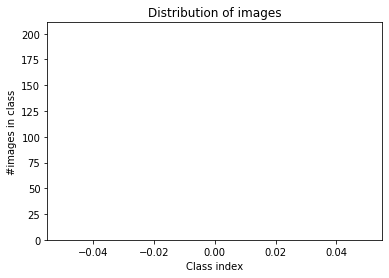

---
# images: 200
# classes: 1

Class with most images: ('Human', 200)
Class with least images: ('Human', 200)

Avg. per class: 200
Mean: 200
---
RAW DATA OVERVIEW


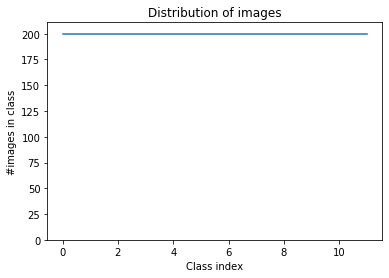

---
# images: 2400
# classes: 12

Class with most images: ('Abyssinian', 200)
Class with least images: ('Abyssinian', 200)

Avg. per class: 200
Mean: 200
---
RAW DATA OVERVIEW


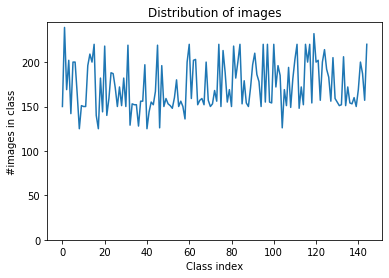

---
# images: 25099
# classes: 145

Class with most images: ('Afghan_hound', 239)
Class with least images: ('Anatolian_shepherd_dog', 125)

Avg. per class: 173
Mean: 173
---
*Start building dataset*

Class Human (generated name: n01000001-Human) - training: 140, validation: 40, test: 20 image(s)
Class Abyssinian (generated name: n02000001-Abyssinian) - training: 140, validation: 40, test: 20 image(s)
Class Bengal (generated name: n02000002-Bengal) - training: 140, validation: 40, test: 20 image(s)
Class Birman (generated name: n02000003-Birman) - training: 140, validation: 40, test: 20 image(s)
Class Bombay (generated name: n02000004-Bombay) - training: 140, validation: 40, test: 20 image(s)
Class British_shorthair (generated name: n02000005-British_shorthair) - training: 140, validation: 40, test: 20 image(s)
Class Egyptian_Mau (generated name: n02000006-Egyptian_Mau) - training: 140, validation: 40, test: 20 image(s)
Class Maine_Coon (generated name: n02000007-Maine_Coon) - training:

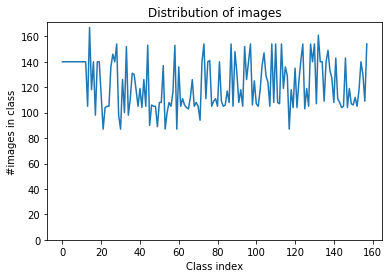

---
# images: 19290
# classes: 158

Class with most images: ('Afghan_hound', 167)
Class with least images: ('Anatolian_shepherd_dog', 87)

Avg. per class: 122
Mean: 122
---
VALIDATION DATASET


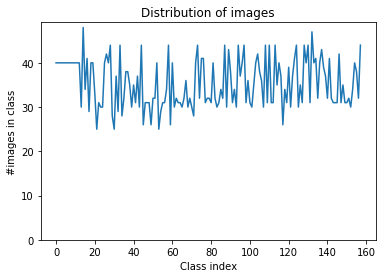

---
# images: 5587
# classes: 158

Class with most images: ('Afghan_hound', 48)
Class with least images: ('Anatolian_shepherd_dog', 25)

Avg. per class: 35
Mean: 35
---
TEST DATASET


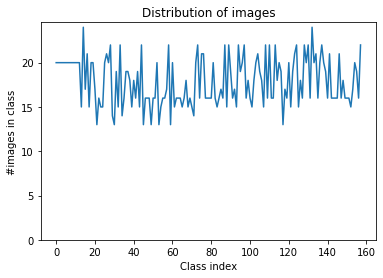

---
# images: 2822
# classes: 158

Class with most images: ('Afghan_hound', 24)
Class with least images: ('Anatolian_shepherd_dog', 13)

Avg. per class: 17
Mean: 17
---
labels.txt file raw content
['n01000001-Human\n' 'n02000001-Abyssinian\n' 'n02000002-Bengal\n'
 'n02000003-Birman\n' 'n02000004-Bombay\n' 'n02000005-British_shorthair\n'
 'n02000006-Egyptian_Mau\n' 'n02000007-Maine_Coon\n' 'n02000008-Persian\n'
 'n02000009-Ragdoll\n' 'n02000010-Russian_blue\n' 'n02000011-Siamese\n'
 'n02000012-Sphynx\n' 'n03000001-Affenpinscher\n'
 'n03000002-Afghan_hound\n' 'n03000003-African_hunting_dog\n'
 'n03000004-Airedale\n' 'n03000005-Akita\n' 'n03000006-American_bulldog\n'
 'n03000007-American_pit_bull_terrier\n'
 'n03000008-American_Staffordshire_terrier\n'
 'n03000009-Anatolian_shepherd_dog\n' 'n03000010-Appenzeller\n'
 'n03000011-Australian_cattle_dog\n' 'n03000012-Australian_shepherd\n'
 'n03000013-Australian_terrier\n' 'n03000014-Basenji\n'
 'n03000015-Basset_hound\n' 'n03000016-Beagle\n'


In [7]:
dataPath = ''

#desired distribution of images between training/validation/test dirs per class
trainingRatio = 0.7
validationRatio = 0.2
testRatio = 0.1

evaluateRawDataset(dataPath + 'raw data\\humans')
evaluateRawDataset(dataPath + 'raw data\\cats')
evaluateRawDataset(dataPath + 'raw data\\dogs')

trainingPath, validationPath, testPath, labels = buildDataset(dataPath, trainingRatio, validationRatio, testRatio)